<a href="https://colab.research.google.com/github/p-ai-org/p-sync/blob/main/P-sync%20Mental%20Health%20Community%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libs, files, etc. 

In [554]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import to_rgba
import pandas as pd
import os

!pip install quantumrandom
import quantumrandom

!pip install easyesn
from easyesn import PredictionESN

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


### Helper Functions

In [555]:
def thread(color):
    return to_rgba(color, alpha=0.05)

In [556]:
def rolling_window(a, window): # function from https://rigtorp.se/2011/01/01/rolling-statistics-numpy.html
  shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
  strides = a.strides + (a.strides[-1],)
  return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
def rolling_rms(a, window):
  return np.sqrt(np.mean(rolling_window(a, window)**2, axis=1))

from math import floor, ceil
def visualize_results(data, predicted, stepwise_prediction=True, step_size=1):
  sse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
    predicted[0:errorLen] ) )
  # ssto = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
  #     np.mean(data[trainLen+1:trainLen+errorLen+1]) ) )
  # adjRSq = 1 - (sse/(errorLen-inSize))/(ssto/(errorLen-1))
  mse = sse/errorLen

  plt.figure(1).clear()
  plt.plot( range(trainLen+1, trainLen+errorLen+1), data[trainLen+1:trainLen+errorLen+1], 'g', alpha=0.5 )
  plt.plot( range(trainLen+1, trainLen+errorLen+1), predicted[0:errorLen], 'b', alpha=0.5 )
  plt.title('Sample of target and generated signals $y(n)$')
  plt.legend(['Target signal', 'Stepwise predicted signal'])
  # plt.figtext(.5, 0, 'Adjusted $R^2$ = ' + str( adjRSq )[:5], ha='center')
  plt.figtext(.5, 0, 'MSE = ' + str( mse )[:5], ha='center')
  
  error = predicted[0:errorLen] - data[trainLen+1:trainLen+errorLen+1]
  rms_win_len = min(len(error), 100)
  error_rms = rolling_rms(error, rms_win_len)

  fig = plt.figure(2)
  ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
  fig.suptitle('Error (raw and RMS)')
  ax1.plot( range(trainLen+1, trainLen+errorLen+1), error, 'r', label='Error (ideally 0)', alpha=0.5 )
  rms_support = range(trainLen+1+floor(rms_win_len / 2), trainLen+errorLen+1-ceil(rms_win_len / 2)+1)
  ax2.plot( rms_support, error_rms, 'r', alpha=0.5 )
  if stepwise_prediction:
    stepShiftError = predicted[0:errorLen] - data[trainLen+1-step_size:trainLen+errorLen+1-step_size]
    stepShiftError_rms = rolling_rms(stepShiftError, rms_win_len)
    ax1.plot( range(trainLen+1, trainLen+errorLen+1), stepShiftError, 'y', label='Time-shifted error (ideally greater than error)', alpha=0.5 )
    ax2.plot( rms_support, stepShiftError_rms, 'y', alpha=0.5 )
    relativeError = stepShiftError_rms - error_rms
    ax3.plot( rms_support, relativeError, 'k', alpha=0.5 )
  ax1.legend()
  ax3.legend()
  fig.show()

  plt.figure(4).clear()
  plt.plot( range(trainLen+1, trainLen+testLen+1), data[trainLen+1:trainLen+testLen+1], 'g', alpha=0.5 )
  plt.plot( range(trainLen+1, trainLen+testLen+1), predicted, 'b', alpha=0.5 )
  plt.title('Target and generated signals $y(n)$')
  plt.legend(['Target signal', 'Stepwise predicted signal'])

  plt.figure(5).clear()
  plt.plot( range(0, trainLen+testLen+1), data[:trainLen+testLen+1], 'g', alpha=0.5 )
  plt.plot( range(trainLen+1, trainLen+testLen+1), predicted, 'b', alpha=0.5 )
  plt.title('Target and generated signals $y(n)$ starting at $n=0$')
  plt.legend(['Target signal', 'Stepwise predicted signal'])  

## Fetch real-world data

In [557]:
![ ! -d "p-sync" ] && git clone --depth 1 https://github.com/p-ai-org/p-sync.git
# ![ -d "p-sync" ] && cd p-sync && git pull

# time_series = pd.read_csv("p-sync/GoogleTrendsSampleDataset.csv", comment=';')
# time_series.head()

In [558]:
# load in data files

path_keywords = "p-sync/data/keywords"
path_subreddits = "p-sync/data/subreddits"

def subredditsToDf(folderpath, suffix="_subcountchange"):
  alldata = pd.DataFrame()
  for c in os.listdir(folderpath):
    newdf = pd.read_csv(os.path.join(folderpath, c)).set_index('month')
    name = c[:len(c)-4] # chop off ".csv"
    # print(name)
    newdf = newdf.drop(columns=['firstday'])
    newdf.columns = [name + suffix]
    # newdf = newdf.diff()

    if alldata.shape == (0, 0): # if its empty, initialize it
      alldata = newdf
    else: # if data already exists, add a new column of the subreddit's subcountchange
      alldata = alldata.join(newdf, how='outer', on='month')
  return alldata

def keywordsToDf(folderpath, suffix='_usagecount'):
  alldata = pd.DataFrame()
  for c in os.listdir(folderpath):
    newdf = pd.read_csv(os.path.join(folderpath, c))
    newdf = newdf.reindex(range(1, len(newdf)))
    newdf.index.name = 'month'
    keyword = c[:len(c)-4] # chop off ".csv"
    # print(keyword)
    countColName = keyword + suffix
    newdf[countColName] = newdf['countincomments'] + newdf['countinposts']
    newdf = newdf[[countColName]] #.drop(columns=['countincomments', 'countinposts', 'firstday', 'lastday'])

    # newdf = newdf.diff()

    if alldata.shape == (0, 0): # if its empty, initialize it
      alldata = newdf
    else: # if data already exists, add a new column of the subreddit's subcountchange
      alldata = alldata.join(newdf, how='outer', on='month')
  return alldata

In [636]:
subreddit_df = subredditsToDf(path_subreddits, suffix='_subcountchange')
subreddit_df.plot(legend=False)

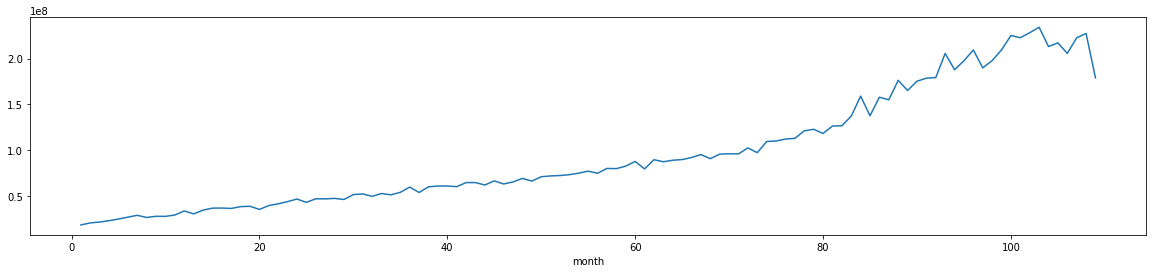

In [475]:
keyword_df = keywordsToDf(path_keywords, suffix='_usagecount')
keyword_df.head()

allwords_counts = keyword_df['ALLWORDS_usagecount']
keyword_df = keyword_df.drop(columns='ALLWORDS_usagecount')

keyword_df.plot(legend=False)
plt.figure()
allwords_counts.plot()

In [476]:
print(keyword_df.shape)

keyword_df.tail()

(109, 272)


,strong_usagecount,unaccepted_usagecount,insult_usagecount,depression_usagecount,successful_usagecount,proud_usagecount,glee_usagecount,poor_usagecount,alone_usagecount,pathetic_usagecount,...,elated_usagecount,panic_usagecount,nasty_usagecount,afraid_usagecount,prosperous_usagecount,gloomy_usagecount,unprotected_usagecount,ill_usagecount,suffocated_usagecount,rosy_usagecount
month,,,,,,,,,,,,,,,,,,,,,
105,704135,251,108917,225172,249635,366386,6829,634551,812916,147744,...,3356,123889,115917,317688,6453,5343,11216,331881,3587,4567
106,648410,264,93623,209736,227796,282373,6180,559200,740613,130559,...,3022,113410,103039,285105,6029,5013,10403,296972,3036,3684
107,686929,286,100915,231295,250730,301716,6745,637052,834551,137302,...,3240,119518,117165,302682,6409,5100,11370,318148,3355,4027
108,769750,236,91466,211923,242668,317778,6470,593832,776166,129259,...,3145,141469,128470,301825,6629,5262,10913,309368,3404,4117
109,608002,183,73041,170286,196712,218727,5249,482129,640387,97449,...,2119,123760,103664,236322,4887,4014,8187,243497,2410,4940


Preprocess the signals.

In [508]:
subreddit_df_normalized = subreddit_df.diff()
# subreddit_df_normalized = (subreddit_df_normalized-subreddit_df_normalized.min())/(subreddit_df_normalized.max()-subreddit_df_normalized.min())
subreddit_df_normalized = pd.concat([
    subreddit_df_normalized[:69]/subreddit_df_normalized[:69].std(),
    subreddit_df_normalized[69:]/subreddit_df_normalized[69:].std(),
])
# subreddit_df_normalized.plot(legend=False, color=thread('red'))
px.line(subreddit_df_normalized)

Unsupported

In [509]:
print(subreddit_df_normalized.shape)
subreddit_df_normalized.tail()

(102, 244)


,StarTrek_subcountchange,painting_subcountchange,firefly_subcountchange,learnprogramming_subcountchange,BetterCallSaul_subcountchange,flexibility_subcountchange,edmproduction_subcountchange,howyoudoin_subcountchange,Zentangle_subcountchange,boardgames_subcountchange,...,thewalkingdead_subcountchange,beards_subcountchange,aww_subcountchange,scrubs_subcountchange,Jarrariums_subcountchange,cats_subcountchange,30rock_subcountchange,calligraphy_subcountchange,hardcoreaww_subcountchange,cooking_subcountchange
month,,,,,,,,,,,,,,,,,,,,,
106,0.489559,0.142027,-0.169788,0.530704,0.048369,-0.393486,0.528301,0.289907,-0.114548,-0.051153,...,0.159837,-0.097697,0.303396,-0.166511,-0.139890,-0.284285,-0.147724,0.071807,-0.192061,0.462988
107,-2.392010,-1.216232,-2.295111,-1.621998,-2.783639,-1.927833,-2.243573,-2.791323,-2.378633,-2.157536,...,-2.530335,-1.907172,-0.826920,-2.679574,-2.835560,-1.847495,-2.639847,-2.484258,-2.564762,-2.432656
108,-0.176768,-0.710430,0.789277,-0.398012,0.619912,0.673738,-0.173157,0.697288,0.226320,0.070402,...,0.536862,0.122740,-1.313864,0.646525,0.477898,0.692937,0.400836,0.249343,0.599915,0.096782
109,2.167268,2.145858,1.990939,2.261797,2.308515,2.028833,2.296234,2.120443,2.147567,2.142749,...,1.975972,2.789324,1.633638,2.188760,2.630666,2.607656,2.187683,2.251698,2.214318,2.144131
110,1.124077,1.661827,1.016497,1.649685,1.116406,0.035029,1.205922,1.263240,1.323112,1.345929,...,1.243306,1.596757,1.178802,1.161415,1.056653,2.233991,1.018887,1.155420,0.812122,1.382898


In [510]:
# keyword_df_normalized = (keyword_df-keyword_df.min())/(keyword_df.max()-keyword_df.min())
keyword_df_ratio = keyword_df.div(allwords_counts, axis='index') # gets avg rate of change (?)
keyword_df_ratio.columns = keyword_df.columns + 'ratio'

keyword_df_ratio_diff = keyword_df_ratio.diff()
keyword_df_ratio_diff.columns = keyword_df_ratio.columns + 'change'

keyword_df_normalized = keyword_df_ratio_diff.div(keyword_df_ratio_diff.std(), axis='columns')
keyword_df_normalized.columns = keyword_df_ratio_diff.columns + 'norm'

# keyword_df_normalized.plot(legend=False, alpha=0.3, figsize=(8,6))
px.line(keyword_df_normalized)

Unsupported

Split keyword dataframe into 3 for the different categories: *negative, neutral, positive*

In [998]:
# lists for categories' columns

precol_negative = ["negative", "kms", "kys", "stressed", "stress", "anxious", "anxiety", "fear", "scared", "sad", "worried", "depressed", "depression", "sadness", "grief", "insane", "mad", "death", "murder", "kill", "suicide", "suicidal", "self-destruction", "felo-de-se", "unalive", "done with this", "had enough", "fed up", "tired", "ill", "numb", "tired", "fatigued", "angry", "allergic", "sick", "consternated", "upset", "confused", "confusion", "bad", "OCD", "insomnia", "addiction", "narcolepsy", "alone", "lonely", "loneliness", "isolated", "isolation", "heartbroken", "hopeless", "furious", "ashamed", "sorrow", "cry", "crying", "self-destruction", "self-destroy", "afraid", "drugs", "gloomy", "melancholy", "dejected", "hate", "insecure", "unproductive", "burnt out", "joyless", "aimless", "empty", "stagnant", "terrible", "awful", "poor", "bullies", "bullying", "threatening", "threaten", "cheating", "cheat", "sabotage", "rape", "sexual assault", "assault", "mad", "hurt", "hurting", "cancer", "disease", "famine", "war", "hurting", "nightmare", "worst", "fall apart", "hardship", "difficulty", "lazy", "unprotected", "break down", "breakdown", "unloved", "violated", "vulnerable", "unaccepted", "withdrawn", "betray", "betrayal", "betrayed", "trash", "resentful", "resentment", "embarrassed", "embarrassment", "screwed", "ruined", "ruin", "helpless", "guilty", "frightened", "humiliated", "fail", "failure", "fearful", "misunderstood", "mistake", "criticized", "deceived", "attacked", "bitter", "agony", "accused", "accident", "abandoned", "abandonment", "powerless", "panic", "panicky", "insult", "insecure", "incompetent", "suffocated", "smother", "put-down", "manipulated", "nasty", "neglected", "insignificant", "ridicule", "ridiculed", "forgotten", "foolish", "nervous", "wreck", "broken", "pathetic", "mental health", "pull through", "survive", "matter", "believe", "positive", "thriving", "wellness", "good", "great", "happy", "grateful", "amazing", "awesome", "best", "hearty", "gratefulness", "fit", "enjoy", "enjoying", "excited", "excitement", "at peace", "glad", "content", "fortunate", "blissful", "bliss", "love", "lovely", "loving", "merry", "elated", "elation", "cheer", "cheery", "hope", "hopeful", "glee", "happy", "happiness", "loving", "healed", "bless", "killing it", "successful", "mirth", "joy", "joyous", "victory", "well-being", "festive", "festivities", "celebrate", "celebration", "laughing", "laugh", "charming", "charm", "jubilant", "yay", "woohoo", "like", "adore", "healthy", "confident", "confidence", "sexy", "LOL", "lmao", "lls", "haha", "hahaha", "lmfao", "awesome", "in love", "secure", "motivated", "peace", "peaceful", "yoga", "exercise", "optimistic", "productive", "productivity", "liberty", "free", "pride", "proud", "lucky", "luck", "calm", "community", "prosperous", "rich", "friends", "friend", "parties", "party", "lively", "spirited", "active", "exploring", "explore", "play", "playful", "rosy", "satisfaction", "satisfying", "exhilarated", "nice", "positive", "genial", "treasure", "dream", "fortunate", "happiness", "wealth", " meaning", "gratification", "ecstatic", "best", "upbeat", "uplift", "uplifted", "strong", "clever", "smart", "crafty", "witty", "insightful", "appreciated", "appreciation", "appreciate", "comfortable", "energetic", "energy", "powerful", "delight", "delightful", "delighted", "impressed", "cute", "pretty", "hallelujah", "amuse", "amused", "inspirational", "inspired", "inspire", "cozy", "togetherness", "upbeat", "camaraderie", "fresh", "lighthearted", "magical", "grace", "gracious", "delicious", "yummy", "soothing", "smile", "smiling", "quality", "sunset", "sunrise", "overjoyed", "sunshine", "thank you", "thanks", "thankful", "welcome", "diverse", "included", "diversity", "inclusion"] #, ":("]
precol_neutral = ["mental health", "pull through", "survive", "matter", "believe"]
precol_positive = ["positive", "thriving", "wellness", "good", "great", "happy", "grateful", "amazing", "awesome", "best", "hearty", "gratefulness", "fit", "enjoy", "enjoying", "excited", "excitement", "at peace", "glad", "content", "fortunate", "blissful", "bliss", "love", "lovely", "loving", "merry", "elated", "elation", "cheer", "cheery", "hope", "hopeful", "glee", "happy", "happiness", "loving", "healed", "bless", "killing it", "successful", "mirth", "joy", "joyous", "victory", "well-being", "festive", "festivities", "celebrate", "celebration", "laughing", "laugh", "charming", "charm", "jubilant", "yay", "woohoo", "like", "adore", "healthy", "confident", "confidence", "sexy", "LOL", "lmao", "lls", "haha", "hahaha", "lmfao", "awesome", "in love", "secure", "motivated", "peace", "peaceful", "yoga", "exercise", "optimistic", "productive", "productivity", "liberty", "free", "pride", "proud", "lucky", "luck", "calm", "community", "prosperous", "rich", "friends", "friend", "parties", "party", "lively", "spirited", "active", "exploring", "explore", "play", "playful", "rosy", "satisfaction", "satisfying", "exhilarated", "nice", "positive", "genial", "treasure", "dream", "fortunate", "happiness", "wealth", " meaning", "gratification", "ecstatic", "best", "upbeat", "uplift", "uplifted", "strong", "clever", "smart", "crafty", "witty", "insightful", "appreciated", "appreciation", "appreciate", "comfortable", "energetic", "energy", "powerful", "delight", "delightful", "delighted", "impressed", "cute", "pretty", "hallelujah", "amuse", "amused", "inspirational", "inspired", "inspire", "cozy", "togetherness", "upbeat", "camaraderie", "fresh", "lighthearted", "magical", "grace", "gracious", "delicious", "yummy", "soothing", "smile", "smiling", "quality", "sunset", "sunrise", "overjoyed", "sunshine", "thank you", "thanks", "thankful", "welcome", "diverse", "included", "diversity", "inclusion"] # , ":)"]

# add on the suffix
col_suffix = "_usagecountratiochangenorm"

# pandas subsets to split dataframe into 3

keyword_negative = keyword_df_normalized[[col + col_suffix for col in precol_negative if col + col_suffix in keyword_df_normalized]]
keyword_neutral = keyword_df_normalized[[col + col_suffix for col in precol_neutral if col + col_suffix in keyword_df_normalized]]
keyword_positive = keyword_df_normalized[[col + col_suffix for col in precol_positive if col + col_suffix in keyword_df_normalized]]

What's the shape of each new dataframe?

In [1000]:
print("Negative: {0}\nNeutral: {1}\nPositive: {2}".format(keyword_negative.shape, keyword_neutral.shape, keyword_positive.shape))
print("All: {0}".format(keyword_df_normalized.shape[1]))

# print(list(set(precol_positive + precol_negative + precol_neutral) - set(keyword_df_normalized)))

# assert sum((x.shape[1] for x in (keyword_negative, keyword_neutral, keyword_positive))) == keyword_df_normalized.shape[1]


All: 272
Negative: (109, 284)
Neutral: (109, 5)
Positive: (109, 122)

N/A% (0 of 64) |                         | Elapsed Time: 0:20:44 ETA:  --:--:--

Now we have a time-series dataset we can work with (a sequence of values). Let's split our data into train and validation sets.

In [1001]:
def keyword_to_numpy(keyword_input):
    keyword_trends = keyword_input.to_numpy()
    # coordinating the months of the datasets
    inputData = keyword_trends[9:]
    return {"n_input": inputData.shape[1], "trainDataIn": inputData[:trainLen], "validationDataIn": inputData[trainLen:trainLen+testLen]}

In [1002]:
# stepSize = 1

# does it make sense to set nan's to 0?
# subreddit_trends = subreddit_df_normalized.to_numpy(na_value=0)
subreddit_trends = subreddit_df_normalized.to_numpy()
# coordinating the months of the datasets
outputData = subreddit_trends[1:-1:]

trainLen = 75
testLen = 24

# list of the 3 categorical inputs' dictionaries, containing training and validation data numpy arrays
keywordCategories = [keyword_to_numpy(x) for x in (keyword_negative, keyword_neutral, keyword_positive)]

trainDataOut = outputData[:trainLen]
validationDataOut = outputData[trainLen:trainLen+testLen]
n_output = validationDataOut.shape[1]

print(len(outputData))
print(subreddit_trends)
print(trainDataOut.shape)

In [1003]:
print(keywordCategories[0]["trainDataIn"])

In [1004]:
# print(inputData.shape)
# print(validationDataIn.shape)
print(outputData.shape)
print(validationDataOut.shape)


All: 272
100
[[            nan             nan             nan ...             nan
              nan             nan]
 [ 2.86502304e+00  6.76798309e-01  3.74748511e+00 ...  2.30431369e-01
   5.57407128e-02  2.24988227e+00]
 [ 4.36503790e-01  1.28693979e-01  4.90479870e-01 ...  7.64873386e-02
   3.30277363e-03  2.24980441e-01]
 ...
 [-1.76767905e-01 -7.10429590e-01  7.89277414e-01 ...  2.49343340e-01
   5.99915025e-01  9.67820474e-02]
 [ 2.16726831e+00  2.14585753e+00  1.99093882e+00 ...  2.25169785e+00
   2.21431826e+00  2.14413146e+00]
 [ 1.12407729e+00  1.66182699e+00  1.01649734e+00 ...  1.15542035e+00
   8.12121854e-01  1.38289750e+00]]
(75, 244)
[[ 0.28364481 -0.03992894 -0.03996816 ... -0.01886809 -0.47246072
   0.15323016]
 [-0.34769273 -0.27584694  0.05521131 ...  0.19987767 -0.09336757
  -0.83588715]
 [-0.50443794  0.3934451  -0.06452749 ...  0.62863598 -0.75583178
   0.90613462]
 ...
 [ 0.09224293  0.52347815 -1.33747811 ... -0.53425114  0.04376317
  -1.35313473]
 [-0.830183

N/A% (0 of 64) |                         | Elapsed Time: 0:20:44 ETA:  --:--:--

In [1005]:
# # messing around
# sub_input_test = subreddit_df_normalized[["StarTrek_subcountchange", "painting_subcountchange", "firefly_subcountchange"]].to_numpy(na_value=0)
# print(sub_input_test)

In [1006]:
subreddit_df_normalized[1:-1].tail()

,StarTrek_subcountchange,painting_subcountchange,firefly_subcountchange,learnprogramming_subcountchange,BetterCallSaul_subcountchange,flexibility_subcountchange,edmproduction_subcountchange,howyoudoin_subcountchange,Zentangle_subcountchange,boardgames_subcountchange,...,thewalkingdead_subcountchange,beards_subcountchange,aww_subcountchange,scrubs_subcountchange,Jarrariums_subcountchange,cats_subcountchange,30rock_subcountchange,calligraphy_subcountchange,hardcoreaww_subcountchange,cooking_subcountchange
month,,,,,,,,,,,,,,,,,,,,,
105,2.042302,2.670208,1.550059,2.632954,1.823272,0.671859,1.916630,1.979646,1.849812,2.834842,...,2.420536,2.287697,2.460675,2.098457,2.229829,0.718821,2.102522,2.128599,1.783840,2.638860
106,0.489559,0.142027,-0.169788,0.530704,0.048369,-0.393486,0.528301,0.289907,-0.114548,-0.051153,...,0.159837,-0.097697,0.303396,-0.166511,-0.139890,-0.284285,-0.147724,0.071807,-0.192061,0.462988
107,-2.392010,-1.216232,-2.295111,-1.621998,-2.783639,-1.927833,-2.243573,-2.791323,-2.378633,-2.157536,...,-2.530335,-1.907172,-0.826920,-2.679574,-2.835560,-1.847495,-2.639847,-2.484258,-2.564762,-2.432656
108,-0.176768,-0.710430,0.789277,-0.398012,0.619912,0.673738,-0.173157,0.697288,0.226320,0.070402,...,0.536862,0.122740,-1.313864,0.646525,0.477898,0.692937,0.400836,0.249343,0.599915,0.096782
109,2.167268,2.145858,1.990939,2.261797,2.308515,2.028833,2.296234,2.120443,2.147567,2.142749,...,1.975972,2.789324,1.633638,2.188760,2.630666,2.607656,2.187683,2.251698,2.214318,2.144131


In [1007]:
# keyword_df_normalized[9:].tail()
keyword_negative[9:].tail()

,negative_usagecountratiochangenorm,kms_usagecountratiochangenorm,kys_usagecountratiochangenorm,stressed_usagecountratiochangenorm,stress_usagecountratiochangenorm,anxious_usagecountratiochangenorm,anxiety_usagecountratiochangenorm,fear_usagecountratiochangenorm,scared_usagecountratiochangenorm,sad_usagecountratiochangenorm,...,wealth_usagecountratiochangenorm,meaning_usagecountratiochangenorm,gratification_usagecountratiochangenorm,ecstatic_usagecountratiochangenorm,best_usagecountratiochangenorm,upbeat_usagecountratiochangenorm,uplift_usagecountratiochangenorm,uplifted_usagecountratiochangenorm,strong_usagecountratiochangenorm,upbeat_usagecountratiochangenorm
month,,,,,,,,,,,,,,,,,,,,,
105,1.985895,1.501841,0.505439,0.511225,0.642726,-0.132816,0.479060,0.504242,0.970974,1.885466,...,0.300688,1.791230,-0.247397,0.430329,1.132629,-1.217651,0.658807,0.398789,1.561497,-1.217651
106,-2.343434,-0.775553,-0.472559,-0.400237,-0.327274,0.120402,-0.184041,-0.818953,-1.042123,-0.468904,...,-0.813649,-2.133468,-0.096260,-0.226507,-1.157194,-0.973186,-0.524714,-0.339019,-0.881302,-0.973186
107,0.573244,0.251716,0.448205,-0.974700,-0.633932,-0.378145,-0.336156,-0.726268,-0.945905,-0.842569,...,1.450328,0.942260,0.498272,-0.094547,1.410148,-0.110462,-0.800798,0.009952,-0.680872,-0.110462
108,-1.696242,-1.061851,-0.549956,-1.342194,-1.300732,-0.237041,-1.350717,-0.029365,1.047351,-2.312369,...,0.002236,-0.507408,-1.174783,-0.212954,-1.915032,-0.258481,-0.977150,-0.001383,2.962940,-0.258481
109,1.182453,0.093222,0.046131,0.342788,0.698305,-0.057458,-0.091006,-0.265140,-0.815352,-0.185195,...,0.489095,0.514647,1.577119,-0.138950,-0.698066,0.186093,0.476649,0.571966,0.141730,0.186093


## One-step prediction

Now let's fit a model.

Initialize the helper functions

In [1008]:
# assumes that the input shapes are matrices, with the columns as the different subreddits
# the resulting shape should be a (1,n_output) np array
def subredditMSE(predict, actual):
    return (np.square(predict - actual)).mean(axis=0)

In [1009]:
# setting up reservoir
# n_output = 244

def predictSubreddit(num_seed, n_input, trainDataIn, validationDataIn):
    np.random.seed(num_seed)
    resSize = 350
    esn = PredictionESN(n_input=n_input, n_output=n_output,
                        n_reservoir=resSize, # size of reservoir (number of nodes)
                        leakingRate=0.9, # when a node receives a signal, *how much of it* will it send to nodes it is connected to?
                                        # (the rest will be "absorbed" rather than exciting next node)
                        spectralRadius=1.0, # how far into the "future" can a signal echo? (i.e. when the reservoir is procedurally
                                            # generated at the beginning, how long of a path can a new connection be a shortcut for?)
                                            # also determines the time constant, i.e. how quickly signals decay in the reservoir
                        regressionParameters=[1e-3], # how much smoothing do we want the regression to use? (e.g. 1e-2 is smoothing more than 1e-8)
                        solver="lsqr") # solve for the output weights by minimizing least-squares 

    # fitting output weights (?)
    # print(n_input, trainDataIn.shape, trainDataOut.shape)
    trainError = esn.fit(trainDataIn, trainDataOut, transientTime="Auto", verbose=1)
    # print("--")
    return {"num_seed": num_seed, "predict": esn.predict(validationDataIn, verbose=1), "trainError": trainError}

In [1010]:
# get mean MSE for a given keyword category
predictions = []
def ensemblePredict(keywordDict, listSeeds):
    ensembleMSE = np.empty([0, n_output])
    for seed in listSeeds:
        prediction = predictSubreddit(seed, keywordDict["n_input"], keywordDict["trainDataIn"], keywordDict["validationDataIn"])
        newMSE = subredditMSE(prediction["predict"], validationDataOut)
        
        predictions.append(prediction["predict"])

        ensembleMSE = np.vstack((ensembleMSE, newMSE))
    meanMSEs = ensembleMSE.mean(axis=0)
    return meanMSEs

Run predictions for all keyword categories and subreddits

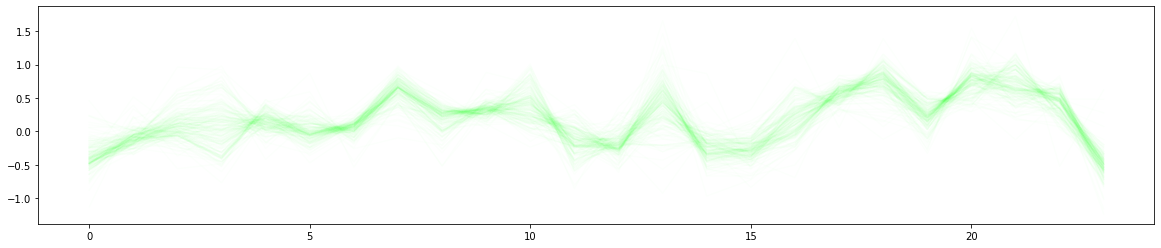

In [1035]:
# plt.plot(validationDataOut, color=(1,0,0,0.01), label="reference")
plt.plot(predictions[0], color=(0,1,0,0.01), label="negative")
# plt.figure()
# plt.figure()
# plt.plot(predictions[1], color=(0,0,1,0.01), label="neutral")
# plt.figure()
# plt.plot(predictions[2], color=(0,1,1,0.01), label="positive")
# plt.legend()

In [1012]:
# generate random ints for testing different seeds
# change array_length param for desired # of different seeds
random_seeds = quantumrandom.get_data(data_type='uint16', array_length=1) # 10)

# gather mean MSEs for all subreddits, separated by the 3 different keyword categories 
categorySubredditMSE = np.array([ensemblePredict(keyIn, random_seeds) for keyIn in keywordCategories])

(24, 244)


100% (67 of 67) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (24 of 24) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (24 of 24) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (65 of 65) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (24 of 24) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [1013]:
print(random_seeds)

[47369]


N/A% (0 of 64) |                         | Elapsed Time: 0:20:47 ETA:  --:--:--

In [1014]:
# generate list of predictions
# list of unnecessary dictionaries keys: {num_seed, predict, trainError}

# results = [predictSubreddit(result) for result in random_seeds]

In [1015]:
# print(len(trainDataIn[-1]))
# print(validationDataIn.shape)
# generation = esn.generate(n=len(validationDataOut), inputData=None, initialOutputData=trainDataOut[-1])
# plt.plot(generation[0, :])
# plt.plot(validationDataIn)
# plt.show()

# print(categorySubredditMSE.shape)

categorySubredditMSE_df = pd.DataFrame(categorySubredditMSE, columns=subreddit_df.columns.map(lambda name: name[:-15]), index=["negative", "neutral", "positive"]).melt(ignore_index=False, var_name="subreddit", value_name="mean_mse")
categorySubredditMSE_df["keyword_category"] = categorySubredditMSE_df.index
categorySubredditMSE_df = categorySubredditMSE_df.reset_index()

# categorySubredditMSE_df

# categorySubredditMSE_df.plot()
px.line(categorySubredditMSE_df, x="keyword_category", y="mean_mse", color="subreddit")

Unsupported

In [1016]:
# plt.plot(categorySubredditMSE)
# !pip install doex
import doex
doex.TwoWayANOVA(categorySubredditMSE)
categorySubredditMSE

+---------------------+-----+----------------+---------------------+-------------+---------+
| Source of Variation | DOF | Sum of Squares | Mean Sum of Squares | F statistic | p value |
+---------------------+-----+----------------+---------------------+-------------+---------+
|      Treatments     |  2  |      nan       |         nan         |     nan     |   nan   |
|        Blocks       | 243 |      nan       |         nan         |     nan     |   nan   |
|        Error        | 486 |      nan       |         nan         |             |         |
|        Total        | 731 |      nan       |                     |             |         |
+---------------------+-----+----------------+---------------------+-------------+---------+

N/A% (0 of 64) |                         | Elapsed Time: 0:20:49 ETA:  --:--:--

array([[0.88700608, 0.99322645, 0.87848757, 0.89594056, 0.98743393,
        0.86447985, 0.80781062, 1.1130032 ,        nan, 1.13172605,
        1.08149398,        nan, 1.29072901,        nan, 1.18516079,
        0.79355739, 0.89664436,        nan, 0.5582235 , 0.92202302,
               nan, 1.10856082, 0.87072975, 0.84626432, 0.93156667,
        0.93347872,        nan, 0.92333274, 1.00242396,        nan,
        0.7949102 ,        nan, 0.8408486 , 0.75575793, 0.7250112 ,
        1.14410405, 0.8859822 , 1.10439805, 1.16458591,        nan,
        1.19443647,        nan, 1.04198127, 0.91704114, 0.64671922,
        1.1305964 , 0.88124361,        nan,        nan, 0.84576317,
        0.76202355, 0.98078696, 1.15793911, 1.27479775,        nan,
               nan, 0.96697631, 1.12696416,        nan, 1.31104392,
        1.0570232 ,        nan, 1.0372227 , 1.29941224, 0.8993303 ,
        1.01729821, 0.84832596, 0.98989512, 1.30741409, 0.96460889,
        1.17144888, 0.94930562, 1.18077326,     

In [1017]:
!pip install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("mean_mse ~ keyword_category", categorySubredditMSE_df, groups=categorySubredditMSE_df["subreddit"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

# data = sm.datasets.get_rdataset('dietox', 'geepack').data
# md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

In [1018]:
sm.datasets.get_rdataset('dietox', 'geepack').data

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [1019]:
# one_step_prediction[:].shape, outputData.shape

ValueError: ValueError: x and y can be no greater than 2-D, but have shapes (3,) and (3, 24, 244)

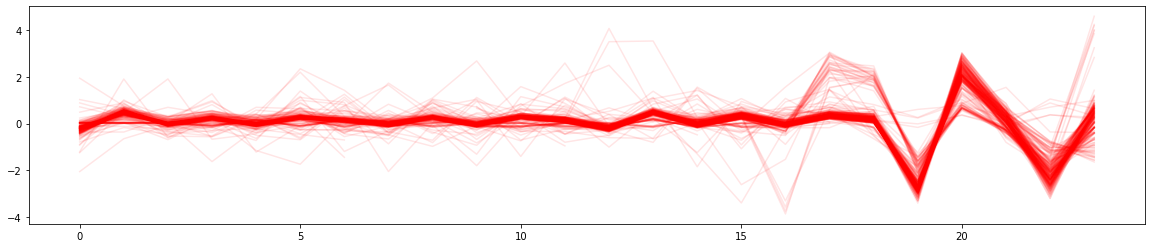

In [1020]:
# errorLen = testLen # used within visualize_results
# visualize_results(outputData, one_step_prediction[:, 0], stepwise_prediction=True, step_size=stepSize)
# plt.show()

# plt.figure().clear()
# plt.plot(validationDataOut, label="future")
# plt.plot(validationDataIn, label="present")
# plt.legend()
# plt.show()

# TODO: save `prediction` for each call to `predictSubreddit` so we can draw "thread plots" like below, and the residual plots below as well

plt.plot(validationDataOut, label="referenceoutput", color=(1,0,0,0.1)) #red
plt.plot(predictions, label="predicted_output", color=(0,0,1,0.1)) #blue
# plt.legend()
plt.show()

In [1021]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(validationDataOut[0], label="referenceoutput", color=(1,0,0,0.1))
plt.plot(one_step_prediction[0], label="predicted_output", color=(0,0,1,0.1))
# plt.legend()
plt.show()

In [1022]:
print(random_seeds)

[47369]


N/A% (0 of 64) |                         | Elapsed Time: 0:20:53 ETA:  --:--:--

In [1023]:
# Plot error (residuals)
# px.line(one_step_prediction - validationDataOut)
px.line(results[0]["predict"] - validationDataOut)

NameError: NameError: name 'results' is not defined

In [1024]:
px.line(results[3]["predict"] - validationDataOut)

NameError: NameError: name 'results' is not defined

In [1025]:
px.line(results[2]["predict"] - validationDataOut)

NameError: NameError: name 'results' is not defined

# Command space

In [1026]:
# !cd p-sync && git pull

# !cat p-sync/data/fetch_reddit_data.py

In [1027]:
!pip install psaw
!touch p-sync/data/fetch_reddit_data.py.log
!cd p-sync/data && python fetch_reddit_data.py

03:34:33,425 root INFO {'firstday': Timestamp('2020-04-30 00:00:00+0000', tz='UTC', freq='M'), 'lastday': Timestamp('2020-05-31 00:00:00+0000', tz='UTC', freq='M'), 'countincomments': 14248, 'countinposts': 3882}
03:34:34,75 psaw.PushshiftAPI INFO https://api.pushshift.io/reddit/comment/search?q=soothing&limit=0&after=1590883200&before=1593475200&metadata=true&sort=desc
03:34:34,556 psaw.PushshiftAPI INFO https://api.pushshift.io/reddit/submission/search?q=soothing&limit=0&after=1590883200&before=1593475200&metadata=true&sort=desc
03:34:34,557 root INFO {'firstday': Timestamp('2020-05-31 00:00:00+0000', tz='UTC', freq='M'), 'lastday': Timestamp('2020-06-30 00:00:00+0000', tz='UTC', freq='M'), 'countincomments': 12960, 'countinposts': 3437}
03:34:34,988 psaw.PushshiftAPI INFO https://api.pushshift.io/reddit/comment/search?q=soothing&limit=0&after=1593475200&before=1596153600&metadata=true&sort=desc
03:34:35,813 psaw.PushshiftAPI INFO https://api.pushshift.io/reddit/submission/search?q=s

N/A% (0 of 64) |                         | Elapsed Time: 3:56:17 ETA:  --:--:--

In [1028]:
# !tar zcfv keywords.tar.gz p-sync/data/keywords

In [1029]:
# !mv /workspace/p-sync/data/keywords/\*.csv /workspace/p-sync/data/keywords/ALLWORDS.csv

In [1030]:
# !cd p-sync && git pull
# !cd p-sync && git add data && git commit -m "have data collector log to console" && git push
# !cd p-sync && git status

## Git Access Setup

Only need to do once per runtime session:

Setting up the ssh key generated in datalore Account Settings to work with github (as a deploy key, at least; probably also would work as an account-level ssh key):

In [1031]:
# # taken some pieces from https://serverfault.com/a/701637

# !mkdir /workspace/.private/tmp/
# !ssh-keyscan github.com >> /workspace/.private/tmp/githubKey
# !ssh-keygen -lf /workspace/.private/tmp/githubKey
# # Then manually verify against RSA fingerprint listed here: https://api.github.com/meta

# !if ssh-keygen -F github.com; then echo "github.com already trusted; not appending fingerprint to ~/.ssh/known_hosts"; else cat /workspace/.private/tmp/githubKey >> ~/.ssh/known_hosts; fi

# !echo $(cat /var/datalore/manager/.ssh/config | grep -oP '(?<=IdentityFile ).*' | grep -oP '(?<=\.ssh/).*') > /workspace/.private/tmp/keyPath

# # Then we add with ssh agent the private key in /var/data/lore/manager/.ssh that has the same filename as what has just been logged
# !ssh-agent bash -c "ssh-add /var/datalore/manager/.ssh/$(cat /workspace/.private/tmp/keyPath)"

# # Test connecting to git using ssh
# !ssh -T git@github.com

# # You can now clear /workspace/.private/tmp

In [1032]:
# !cd p-sync && git remote set-url origin git@github.com:p-ai-org/p-sync.git

In [1033]:
# # !git config --global user.email "jczimm@jczimm.com"
# !git config --global user.name "P-sync Team (from datalore)"